# Data Exploration

![image](./images/johan-van-wambeke-_2VioFUgQVg-unsplash.jpg)

Import the relevant packages and data.

In [474]:
#import packages
import folium
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
import string

In [416]:
#read in data
df = pd.read_csv('./data/Tweets.csv')

In [417]:
#shape
df.shape

(14640, 15)

In [418]:
#column names
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [394]:
#data types by columns and null value overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [395]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Based on a previous analysis, class imbalance appears to be present.

In [419]:
#drop irrelevant columns
df.drop(['tweet_id','negativereason_gold','airline_sentiment_gold','negativereason','airline_sentiment_confidence',
         'airline_sentiment','negativereason_confidence'],axis=1,inplace=True)

In [397]:
df['tweet_coord'].value_counts()

[0.0, 0.0]                      164
[40.64656067, -73.78334045]       6
[32.91792297, -97.00367737]       3
[40.64646912, -73.79133606]       3
[35.22643463, -80.93879965]       2
                               ... 
[40.69429232, -74.17208436]       1
[37.61833841, -122.38389799]      1
[37.61859126, -122.38385699]      1
[45.58931882, -122.5959928]       1
[40.64946781, -73.76624703]       1
Name: tweet_coord, Length: 832, dtype: int64

In [ ]:
#function to remove -008 from data column
def fix_date(dateobject):
    date = str(dateobject)
    return date[0:19]

In [420]:
#fix data type
df['tweet_created'] = df['tweet_created'].map(lambda x:fix_date(x))
df['tweet_created'] = pd.to_datetime(df['tweet_created'],infer_datetime_format=True)

In [421]:
df.head()

,airline,name,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52,NaN,Eastern Time (US & Canada)
1,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59,NaN,Pacific Time (US & Canada)
2,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48,Lets Play,Central Time (US & Canada)
3,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36,NaN,Pacific Time (US & Canada)
4,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45,NaN,Pacific Time (US & Canada)


In [327]:
#function to format coordinate string into list of coordinates
periwinkle = '[28.5, 77.78]'

def get_coords(mystr):
    if mystr != None:
        mapdict = {'[': None, ']':None,",":None,}
        mappingtbl = mystr.maketrans(mapdict)

        newstr = mystr.translate(mappingtbl)
        new = newstr.split()
        gps = []
        for item in new:
            gps.append(float(item))
        return gps
#test function
get_coords(periwinkle)

[28.5, 77.78]

In [422]:
#if the tweet was created in a month other than february, let us know
months = df['tweet_created'].map(lambda x:x.month).to_list()
for month in months:
    if month != 2:
        print('Not February')

In [413]:
#which days in february?
days = df['tweet_created'].map(lambda x:x.day).to_list()
set(days)

{16, 17, 18, 19, 20, 21, 22, 23, 24}

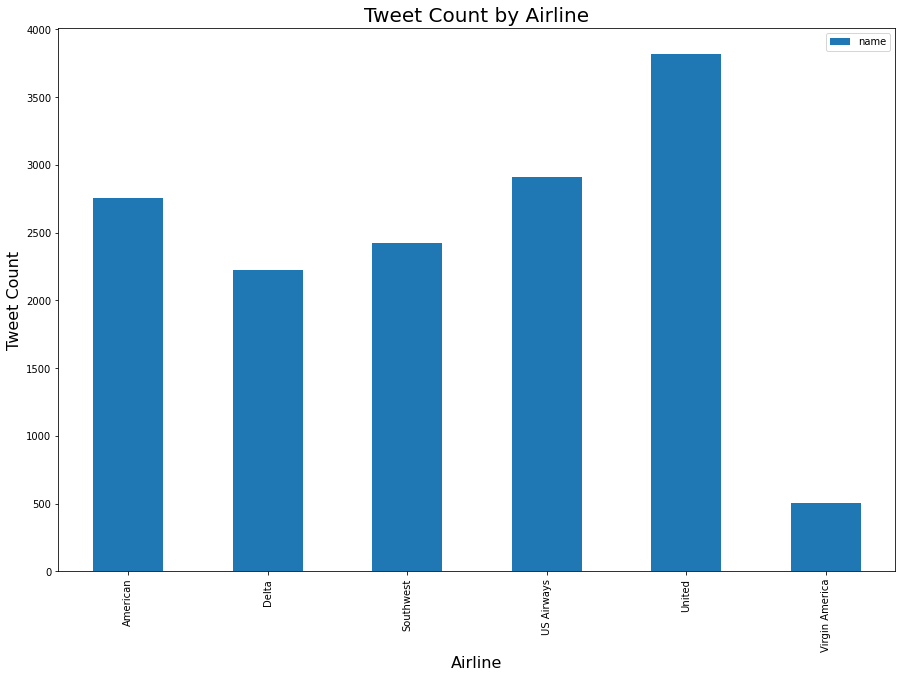

In [414]:
#tweet distribution by airline
df[['airline','name']].groupby(by='airline').count().plot(kind='bar',figsize=(15,10))
plt.title('Tweet Count by Airline',fontdict={'size':20,'color':'black'})
plt.xlabel('Airline',fontdict={'size':16,'color':'black'})
plt.ylabel('Tweet Count',fontdict={'size':16,'color':'black'});

In [424]:
df['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

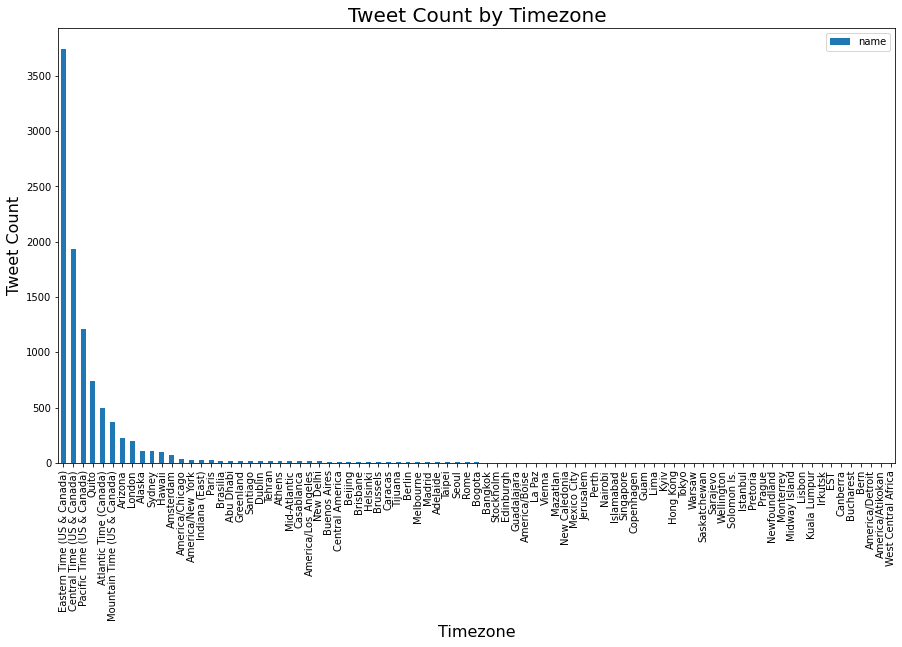

In [415]:
#tweet distribution by timezone
tweet_counts = df[['user_timezone','name']].groupby(by='user_timezone').count()
tweet_counts.sort_values('name',ascending=False).plot(kind='bar',figsize=(15,8))
plt.title('Tweet Count by Timezone',fontdict={'size':20,'color':'black'})
plt.xlabel('Timezone',fontdict={'size':16,'color':'black'})
plt.ylabel('Tweet Count',fontdict={'size':16,'color':'black'});

In [432]:
#for tweets with gps coords, view on map
fig = folium.Figure(width=1000,height=800)
m=folium.Map(location=[28.644800, 77.216721])
has_latlong = df[['name','airline','tweet_coord']].copy(deep=True)
has_latlong.dropna(inplace=True)
has_latlong['tweet_coord'] = has_latlong['tweet_coord'].map(lambda x:get_coords(str(x)))

def assign_colors(airline):
    airlines = ['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways','American'] 
    colors = ['pink','red','green','blue','white','yellow']
    which_color = dict(zip(airlines,colors))
    return which_color[airline]

has_latlong['marker_color'] = has_latlong['airline'].map(lambda x: assign_colors(x))

for index, row in has_latlong.iterrows():
    folium.CircleMarker(location=row['tweet_coord'],radius=10,fill = True,fillOpacity=0.2,popup=row['airline'],tooltip='Click for info',color=row['marker_color']).add_to(m)
fig.add_child(m)

# Preliminary NLP

First I'm removing the tweet data from the dataframe to figure out the the process for cleaning the text most effectively, then I'll implement the process on the dataframe.

In [491]:
#make a list of tweets
tweets = df['text'].to_list()
tweet_sample = tweets[0:50]

In [492]:
type(tweet_sample)

list

Need to remove capitals, punctuation,stopwords.

In [493]:
#define function to do the cleanup
def cleanup(mystr):
    smallwords = stopwords.words('english')
    if mystr != None:
        mappingtbl = mystr.maketrans('','',string.punctuation)
        newstr = mystr.translate(mappingtbl)
        new = newstr.split()
        cleaned = []
        for item in new:
            if item not in smallwords:
                cleaned.append(item.lower())
        return cleaned

In [494]:
#clean the tweets and put them in a new list
clean_tweets = []
for tweet in tweet_sample:
    clean_tweets.append(cleanup(tweet))

In [509]:
clean_tweets[5]

['virginamerica',
 'seriously',
 'would',
 'pay',
 '30',
 'flight',
 'seats',
 'didnt',
 'playing',
 'really',
 'bad',
 'thing',
 'flying',
 'va']

In [496]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,HashingVectorizer
from nltk.probability import FreqDist
from nltk.tokenize import regexp_tokenize,word_tokenize,RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet

In [498]:
lemmatizer= nltk.stem.WordNetLemmatizer()

In [525]:
lemmed_tweets = []
for tweet in clean_tweets:
    lemmed_tweets.append([lemmatizer.lemmatize(word) for word in tweet])

In [528]:
pos_tagged = []
for tweet in lemmed_tweets:
    pos_tagged.append(pos_tag(tweet))

In [536]:
def wordnet_pos(taggedtext):
    if taggedtext.startswith('J'):
        return wordnet.ADJ
    elif taggedtext.startswith('V'):
        return wordnet.VERB
    elif taggedtext.startswith('N'):
        return wordnet.NOUN
    elif taggedtext.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [537]:
correct_tags = []
for tweet in pos_tagged:
    correct_tags.append([(word[0],wordnet_pos(word[1])) for word in tweet])

In [538]:
vec  = CountVectorizer()
X = vec.fit_transform([" ".join(correct_tags[0])])

TypeError: sequence item 0: expected str instance, tuple found

In [522]:
lemmatized = [(tweet[0],wordnet_pos(tweet[1])) for tweet in tweet_tagged]

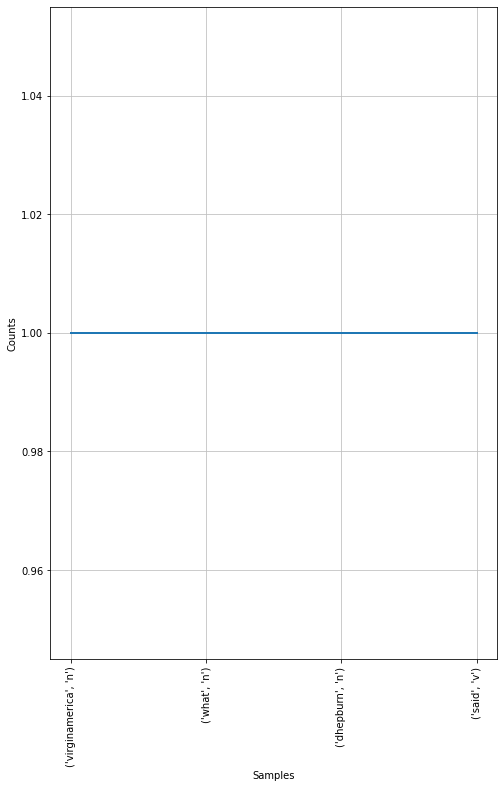

In [524]:
fdist = FreqDist(lemmatized)
plt.figure(figsize=(8,12))
fdist.plot();